In [28]:
import numpy as np
import scipy as sc
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import tf2zpk, lfilter
import sounddevice as sd


In [29]:
def PoleZeroPlot(b, a):
    (zeros,poles,gain) = tf2zpk(b, a);
    angle = np.linspace(-np.pi,np.pi,50)
    cirx = np.sin(angle)
    ciry = np.cos(angle)
    plt.figure()
    plt.plot(poles.real, poles.imag, 'x', zeros.real, zeros.imag, 'o', cirx,ciry, 'k-')
    plt.grid()
    
    plt.xlim((-1.2, 1.2))
    plt.xlabel('Real')
    plt.ylim((-1.2, 1.2))
    plt.ylabel('Imag')
    plt.gcf().set_figwidth(5)
#     return (zeros,poles,gain)

# Speech Production Model
## Consists of
 * Vocal tractct filer (modeling the resonat frequencies of the vocal tract pipe)
 * Excitation signal (Modeling the air flow through the vocal tract)


Let's design Vocal tract filter first,
## Vocal  Tract Filter
* Modeled as all-pole filter

## $H(z) =\frac{1}{(1-\Sigma_{i=0}^{i=p}a_iz^{-i})}=  \frac{G}{(1-z_1z^{-1})(1-z_2z^{-1})\cdots(1-z_pz^{-1}) }$

* Roots of the denominator of $H(z)$ are called poles of the system
* The spectrum peaks at the poles

##  $1-z_iz^{-1} = 0 \implies z = z_i $ is a ploe
Now,let, 
 ##  $z_i = \rho_ie^{(j\omega_i)}$

* $\omega_i$' s constitutes the formant frequencies which in tern associated withe resonant frequencies of the vocal tract pipe
* $\rho_i$' s are associated with the decay of the resonant frequencies

In [30]:
FORMANTt = 'i'
FORMANTt = 'aa'
if FORMANTt == 'i':
    formants_hz = np.array([350, 2200,3380]) #/i//
if FORMANTt =='aa':
    formants_hz = np.array([740, 1180,2640,3485])  #//aa/
    
fs = 8000 # Sampling frequency
formants_radian = formants_hz/fs*2*np.pi
print("Formant Frequencies in Hz       : ",formants_hz)
print("Formant Frequencies in radiance : ", formants_radian)


Formant Frequencies in Hz       :  [ 740 1180 2640 3485]
Formant Frequencies in radiance :  [0.58119464 0.92676983 2.07345115 2.7371126 ]


Now let us bring the $\rho_i$' s into the picture

In [31]:
if FORMANTt == 'i':
     pole_magnitude = np.array([ 0.97, 0.97, 0.92])  #//i//
if FORMANTt == 'aa':    
    pole_magnitude = np.array([ 0.967, 0.88, 0.965, 0.965])  #//aa//
formants = pole_magnitude*np.exp(1j*formants_radian)
formants = np.concatenate((formants,formants.conjugate()))

Now all the poles are ready, let's create $H(z)$ from the poles

In [32]:
P=np.poly(formants)  

print("H(z)= ")
print("1+ ",end ="")
for i in range(1,len(P)): 
    print("{:0.4f} z^-{:}".format(P[i],i),end=" ")
    if i != len(P)-1:
        print("+",end="")

H(z)= 
1+ 0.0309 z^-1 +-0.2986 z^-2 +0.1311 z^-3 +0.8064 z^-4 +0.3790 z^-5 +-0.1333 z^-6 +-0.1190 z^-7 +0.6280 z^-8 

Pole-zero plot of H(z)


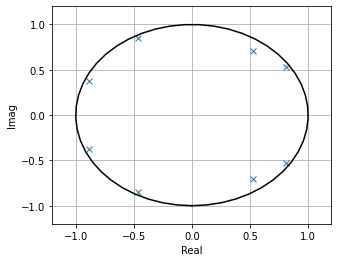

In [33]:
PoleZeroPlot(1, P)
print("Pole-zero plot of H(z)")

(0.0, 4000.0)

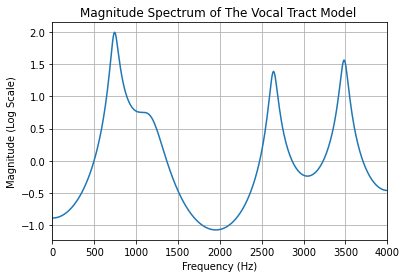

In [34]:
f = signal.freqz(1,P)[1]
plt.title("Magnitude Spectrum of The Vocal Tract Model ")
plt.plot(np.array(range(512))/512*4000,np.log(np.abs(f)));plt.grid();plt.xlabel('Frequency (Hz)'); 
plt.ylabel('Magnitude (Log Scale)')
plt.xlim([0,4000])

## Now, let us design the excitation signal

We are generating voiced signal. Therefore the excitation signal will be an impulse train

(0.0, 500.0)

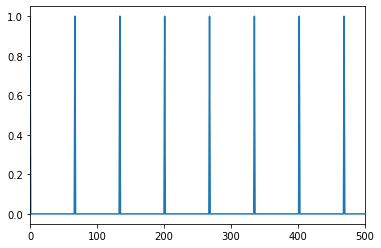

In [35]:
excitation = []
cycle = 600
pitch = 120
period = fs//pitch
for i in range(cycle):
    excitation +=[1]
    excitation += list(np.zeros(period))

excitation = np.array(excitation)
plt.plot(excitation);plt.xlim(0,500)


(0.0, 200.0)

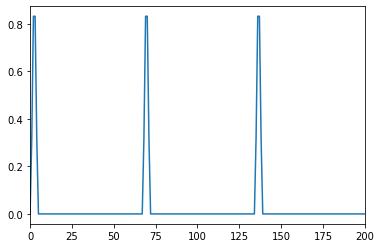

In [36]:
win = np.hamming(6)
win = win -min(win)

excitation = np.convolve(excitation,win )

plt.plot(excitation)
plt.xlim([0,200])

In [37]:
P = np.array(P)
b = np.array([1])
sig = lfilter(b, P, excitation)

In [38]:
sd.play(np.diff(sig),fs)

Text(0.5, 1.0, 'Generated Speech Signal')

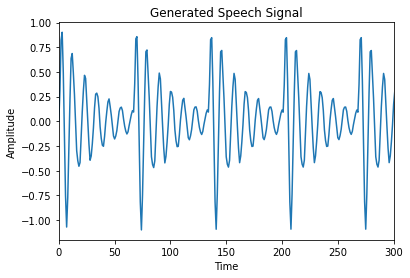

In [39]:
plt.plot(sig);plt.xlim(0,300)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Speech Signal')

(0.0, 4000.0)

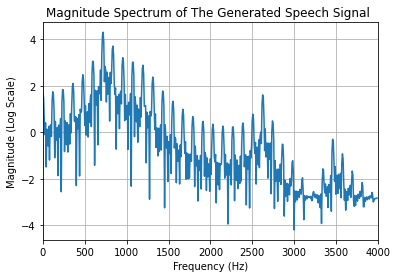

In [41]:

f = signal.freqz(sig[200:600])[1]
plt.title("Magnitude Spectrum of The Generated Speech Signal ")
plt.plot(np.array(range(512))/512*4000,np.log(np.abs(f)));plt.grid();plt.xlabel('Frequency (Hz)'); 
plt.ylabel('Magnitude (Log Scale)');
plt.xlim([0,4000])

# Next, let us generate an unvoiced sound
I created the vocal tract filter using the formant frequencies and bandwidths same as before

We are tying to create the sound /s/


(0.0, 4000.0)

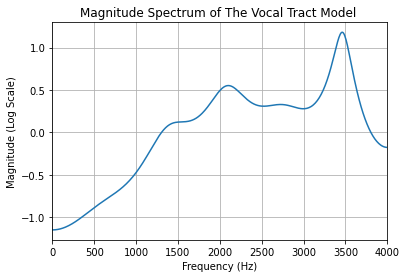

In [42]:
P=[ 1.        ,  0.67196953,  0.59935945,  0.39047003,  0.2546358 ,\
        0.02931081,  0.15220554, -0.0823013 ,  0.07883401, -0.02485103,\
        0.09439204]
f = signal.freqz(1,P)[1]
plt.title("Magnitude Spectrum of The Vocal Tract Model ")
plt.plot(np.array(range(512))/512*4000,np.log(np.abs(f)));plt.grid();plt.xlabel('Frequency (Hz)'); 
plt.ylabel('Magnitude (Log Scale)')
plt.xlim([0,4000])



## For unvoiced sounds excitation is modeled as random noise

Text(0.5, 1.0, 'Excitation (Random Noise)')

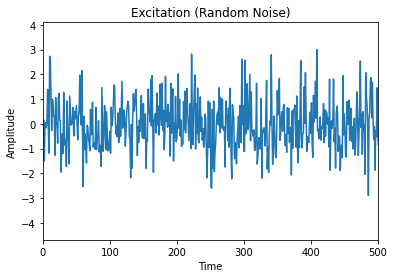

In [43]:
excitation = np.random.randn(5000)
plt.plot(excitation)
plt.xlim([0,500])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Excitation (Random Noise)')


In [46]:
P = np.array(P)
b = np.array([1])
sig = lfilter(b, P, excitation)
sd.play((sig),8000)

Text(0.5, 1.0, 'Generated Speech Signal')

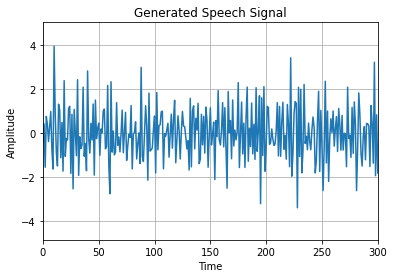

In [45]:
plt.plot(sig);plt.xlim(0,300);plt.grid()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Speech Signal')



(0.0, 4000.0)

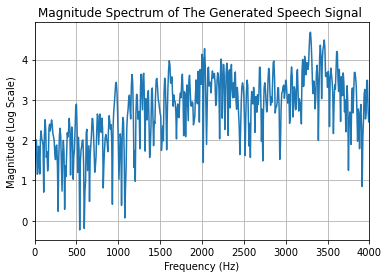

In [47]:
f = signal.freqz(sig[200:600])[1]
plt.title("Magnitude Spectrum of The Generated Speech Signal ")
plt.plot(np.array(range(512))/512*4000,np.log(np.abs(f)));plt.grid();plt.xlabel('Frequency (Hz)'); 
plt.ylabel('Magnitude (Log Scale)');
plt.xlim([0,4000])